<h2><center><font color='Green'> Calculation of Well Head Protection Areas using Capture Zone Analysis </center></h2>

<h3><font color='teal'><center> MD RASHEDUL ISLAM

<hr>

The use of Theis solution for capture zone analysis does not account for the impacts of regional groundwater flow gradients.  As such, other tools for better delineation of capture zones are available.  A schematic description of the capture zones is shown below




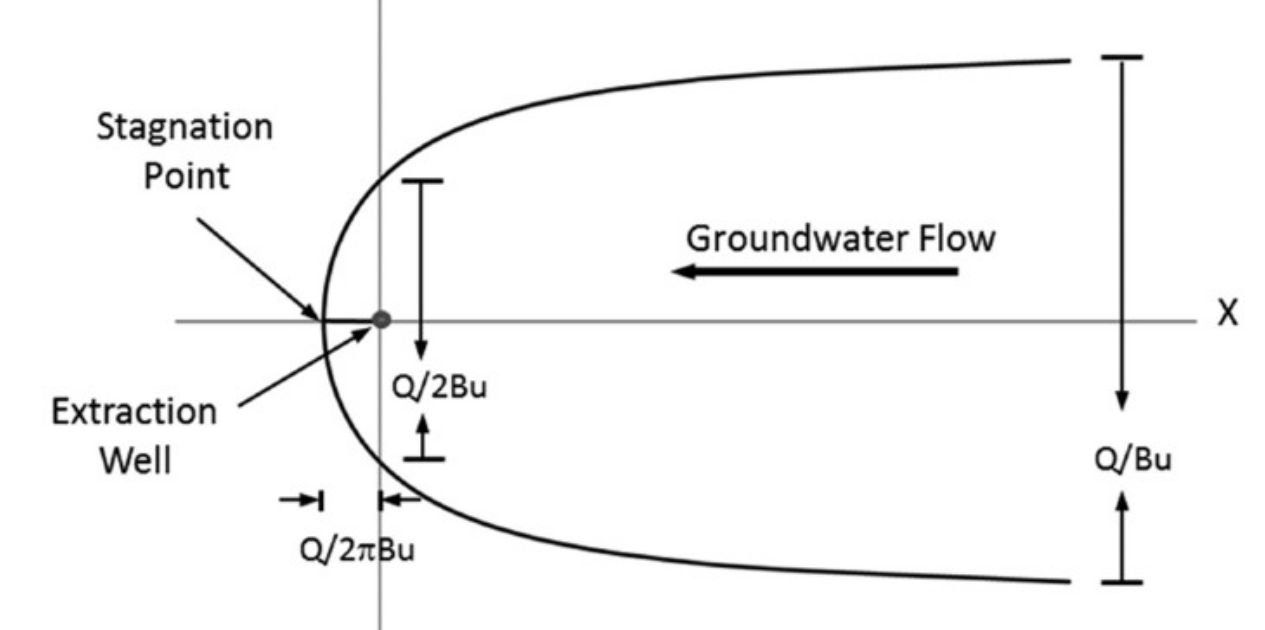

The figure above assumes the well is at a location (0,0).  The stagnation point refers to the point on the X-axis (downgradient of the flow) till which the pumping effects are felt.  The maximum width of the cpature zone along the Y-axis is also given.  We can also obtain the outer curve of the capture zone using the following equations.

$x_s = -\frac{Q}{2\pi BU} $  Where $x_s$ is the stagnation point.  Note as the well is at the origin, the stagnation point is negative

$y_{max} = \pm \frac{Q}{BU} $

For the capture zone boundary, the relationship between x and y is given as follows:

$ x = -\frac{y}{tan\left(\frac{2 \pi UB y}{Q}\right)} $

Where, U is the Darcy velocity (K.i) (ft/d); K is the hydraulic conductivity (ft/d); i is regional groundwater flow gradient.  Q is the pumping rate (ft$^3$/d); B is the aquifer thickness.  Note the product BU can also be written as the product Ti (where T is the aquifer transmissivity ft$^2$/d).  Note any set of consistent units can be used.  **If Albert Equal Area Conic** projection is used then the use of m for length dimension may come handy.  

<h4> Workflow

The computation entails the following steps.
<ol>
<li> Select the dimensions of study (L in m; t in Days); Q will be $m^3/d$ and BU = Ti = $m^2/d$ </li>
<li> Select projection to use.  Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350 </li>
<li> Select the Well Location (get lat-lon coordinates) convert to AEA projection </li>
<li> Extract Transmissivity values at the well (from interpolated T gpkg file) </li>
<li> Obtain the mean water levels (computed earlier) for wells in a gpkg fle </li>
<li> Convert the meam water levels file to AEA projection and compute X and Y coordinates </li>
<li> Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y </li>
<li> Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient </li>
<li> Compute the capture zone polygon in model coordinates (well is at 0,0) </li>
<li> Convert the capture zone polygon to AEA projection coordinates use suitable transformation </li>
<li> Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction</li>
<li> Create a shapely polygon (object) of the capture zone.  Export to a gpkg file
<li> Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.
</ol>

<h4> Codes

<h4> Load Libraries

In [39]:
# Import Libraries
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib_map_utils as mu # To draw north arrow
import statsmodels.api as sm
from matplotlib_scalebar.scalebar import ScaleBar # to draw scalebar
from matplotlib.ticker import FuncFormatter

<h4> Set Working Directory

In [40]:
path = "G:\\GIS\\Mini Project 2"
os.chdir(path)

<h4> Read Files

In [41]:
#Importing GPKG files and converting AEA projection
fname = 'PWells_GAM.gpkg'
Tval = gpd.read_file(fname)
Tvalaea = Tval.to_crs('EPSG:6350')
fname2 = 'JeffersonWGS84.gpkg'
Jefferson = gpd.read_file(fname2)
Jeffaea = Jefferson.to_crs('EPSG:6350')

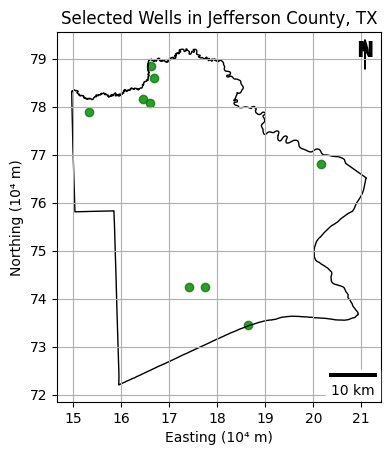

In [49]:
# Scale the Axis label:
def format_ticks(x, pos):
    return f'{x * 1e-4:.0f}'

fig, ax = plt.subplots()

#Plotting data with customized style:
Tvalaea.plot(ax=ax, facecolor='green', edgecolor='green', alpha=0.8)
Jeffaea.plot(ax=ax, facecolor='none', edgecolor='black')

# Add North Arrow using annotation:
ax.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=15,
            ha='center', va='center', fontweight='bold', color='black',
            rotation=0)  # Adjust position and rotation as needed
ax.arrow(0.95, 0.9, 0, 0.05, transform=ax.transAxes, color='black', head_width=0.02)

#Adding a Scale Bar:
scalebar = ScaleBar(1, units="m", location="lower right", length_fraction=0.2)
ax.add_artist(scalebar)

#Setting Axis Labels with a Multiplier:
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.set_xlabel('Easting (10⁴ m)')
ax.set_ylabel('Northing (10⁴ m)')

#Adding Title and Grid:
plt.title('Selected Wells in Jefferson County, TX')
plt.grid()
plt.show()


<li> Select the dimensions of study (L in m; t in Days); Q will be $m^3/d$ and BU = Ti = $m^2/d$ </li>

In [50]:
#Population and Per Capita Usage:
Pop = 20000
pcu = 135  # gallons/day per capita

#Design Time and Other Parameters:
tyears = 10  # 10 years design time
S = 0.005  # Slope or other parameter (assumed from literature)

#Extracting and Converting Transmissivity Values:
T = list(Tval['T_SQFTDay'])  # Assuming Tval is a DataFrame with column 'T_SQFTDay'
BU = [value * 0.092903 for value in T]  # Conversion from square feet per day to square meters per day

#Calculating Pumping Rate:
Q = Pop * pcu * 0.133681  # Converts gallons to cubic feet
Q = Q * 0.0283168  # Converts cubic feet to cubic meters

#Converting Design Time to Days:
t = tyears * 365.25  # Adjusted for leap year

#Printing Results:
print("Transmissivity values (sq ft/day):", T)
print("Converted transmissivity values (sq m/day):", BU)
print("Pumping rate (cubic meter/day):", Q)
print("Design time (days):", t)

Transmissivity values (sq ft/day): [3358, 3352, 3190, 3336, 3315, 3247, 2850, 2902, 3032]
Converted transmissivity values (sq m/day): [311.968274, 311.410856, 296.36057, 309.92440799999997, 307.973445, 301.656041, 264.77355, 269.604506, 281.681896]
Pumping rate (cubic meter/day): 10220.62898016
Design time (days): 3652.5



<li> Select projection to use. Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350 </li>

In [53]:
#Import Necessary Libraries:
import pyproj
from shapely.geometry import Point
from pyproj import CRS

In [54]:
# Define the Albers Equal Area Conic projection with EPSG:6350
albers_proj = CRS("EPSG:6350")
print(albers_proj)

EPSG:6350


In [60]:
# Load the CSV file and display column names
well_df = pd.read_csv("pumpswell.csv")
print(well_df.columns)

Index(['Unnamed: 0', 'StateWellNumber', 'County', 'LongitudeDD', 'LatitudeDD',
       'LandSurfaceElevationMethod', 'WellDepth', 'WaterElevation',
       'DepthFromLSD'],
      dtype='object')


In [61]:
import geopandas as gpd

# Load CSV data
well_df = pd.read_csv("pumpswell.csv")

geometry = [Point(xy) for xy in zip(well_df['LongitudeDD'], well_df['LatitudeDD'])]
well_gdf = gpd.GeoDataFrame(well_df, crs="EPSG:4326", geometry=geometry)

# Define Albers Equal Area projection
albers_proj = CRS("EPSG:6350")

# Transform well locations to AEA projection
well_gdf = well_gdf.to_crs(albers_proj)
print(well_gdf)

   Unnamed: 0  StateWellNumber     County  LongitudeDD  LatitudeDD  \
0           0          6154901  Jefferson   -94.266112   30.134722   
1           3          6154905  Jefferson   -94.271389   30.159167   
2          16          6161602  Jefferson   -94.407223   30.073611   
3          25          6162303  Jefferson   -94.275555   30.089167   
4          26          6162305  Jefferson   -94.291667   30.096389   
5         101          6301301  Jefferson   -93.908612   29.968055   
6         190          6423201  Jefferson   -94.199722   29.742500   
7         191          6423302  Jefferson   -94.164167   29.741389   
8         194          6424502  Jefferson   -94.072778   29.667778   

   LandSurfaceElevationMethod  WellDepth  WaterElevation  DepthFromLSD  \
0  Interpolated From Topo Map       21.0       23.100000      6.900000   
1  Interpolated From Topo Map      572.0      -25.338571     51.338571   
2  Interpolated From Topo Map      300.0       29.300000      6.700000   
3  

In [63]:
print(well_transmissivity.columns)

Index(['Unnamed: 0', 'StateWellNumber_left', 'County_left', 'LongitudeDD_left',
       'LatitudeDD_left', 'LandSurfaceElevationMethod_left', 'WellDepth_left',
       'WaterElevation_left', 'DepthFromLSD_left', 'geometry', 'index_right',
       'StateWellNumber_right', 'County_right', 'LongitudeDD_right',
       'LatitudeDD_right', 'LandSurfaceElevationMethod_right',
       'WellDepth_right', 'WaterElevation_right', 'DepthFromLSD_right',
       'T_SQFTDay', 'T_GPD_ft', 'top_1', 'bot_1', 'bot_2', 'bot_3', 'bot_4',
       'bot_5', 'bot_6'],
      dtype='object')


In [64]:
# Load transmissivity data from GPKG
transmissivity_gdf = gpd.read_file("PWells_GAM.gpkg")

# Ensure transmissivity data is in AEA projection
transmissivity_gdf = transmissivity_gdf.to_crs(albers_proj)

# Perform spatial join to find transmissivity values at each well location
well_transmissivity = gpd.sjoin(well_gdf, transmissivity_gdf, how="inner", predicate="intersects")

# Extract transmissivity values
well_transmissivity_values = well_transmissivity[['StateWellNumber_left', 'T_SQFTDay']]
print(well_transmissivity_values)

   StateWellNumber_left  T_SQFTDay
0               6154901       3358
1               6154905       3352
2               6161602       3190
3               6162303       3336
4               6162305       3315
5               6301301       3247
6               6423201       2850
7               6423302       2902
8               6424502       3032


In [66]:
#Load and Project Mean Water Levels
# Load the CSV file and display column names
water_levels_df = pd.read_csv("GCMeanWL.csv")
print(water_levels_df.columns)

Index(['Unnamed: 0', 'StateWellNumber', 'County', 'LongitudeDD', 'LatitudeDD',
       'LandSurfaceElevationMethod', 'WellDepth', 'WaterElevation',
       'DepthFromLSD'],
      dtype='object')


In [68]:
# Create GeoDataFrame using lat-lon coordinates
geometry = [Point(xy) for xy in zip(water_levels_df['LongitudeDD'], water_levels_df['LatitudeDD'])]
water_levels_gdf = gpd.GeoDataFrame(water_levels_df, crs="EPSG:4326", geometry=geometry)

# Transform mean water levels to AEA projection
water_levels_gdf = water_levels_gdf.to_crs(albers_proj)

# Extract X and Y coordinates for further analysis
water_levels_gdf["LongitudeDD"] = water_levels_gdf.geometry.x
water_levels_gdf["LatitudeDD"] = water_levels_gdf.geometry.y
print(water_levels_gdf[['LongitudeDD', 'LatitudeDD', 'WaterElevation']])

       LongitudeDD     LatitudeDD  WaterElevation
0    166834.846987  785849.276114       23.100000
1    166304.522818  788553.615566      -17.178889
2    166379.619326  788832.555902      -17.287143
3    166277.793526  788553.162588      -25.338571
4    171867.858370  785479.863195       27.000000
..             ...            ...             ...
180  174046.516158  742456.471136        1.800000
181  177485.844115  742399.036392        1.900000
182  177731.680955  742188.147491        1.900000
183  186511.834535  734443.662954        2.500000
184  186485.560801  734412.407858        2.000000

[185 rows x 3 columns]


In [69]:
#Load and Project Jefferson County Boundary
# Load Jefferson County map
jefferson_county_gdf = gpd.read_file("JeffersonWGS84.gpkg")

# Transform Jefferson County map to AEA projection
jefferson_county_gdf = jefferson_county_gdf.to_crs(albers_proj)
print(jefferson_county_gdf)

   CMPTRL_CNT  DPS_CNTY_N FIPS_ST_CN  TXDOT_CNTY  TXDOT_DIST    CNTY_NM  GID  \
0         123         123      48245         124          20  Jefferson   59   

                                            geometry  
0  MULTIPOLYGON (((174150.879 791463.906, 174162....  



<li> Compute the Regional Groundwater Flow Using Linear Regression of Hydraulic Head (from MSL) Against X and Y </li>

In [74]:
from scipy.stats import linregress
# Perform linear regression of hydraulic head (WaterElevation) against X and Y
x_coords = water_levels_gdf["LongitudeDD"]
y_coords = water_levels_gdf["LatitudeDD"]
hydraulic_head = water_levels_gdf["WaterElevation"]

# Linear regression on X coordinates
slope_x, intercept_x, r_value_x, p_value_x, std_err_x = linregress(x_coords, hydraulic_head)

# Linear regression on Y coordinates
slope_y, intercept_y, r_value_y, p_value_y, std_err_y = linregress(y_coords, hydraulic_head)

print("Slope (gradient) along X:", slope_x)
print("Slope (gradient) along Y:", slope_y)

Slope (gradient) along X: -0.0005091280812255789
Slope (gradient) along Y: 0.00025286516016162437



<li> Use the Coefficients of X and Y to Obtain the Gradients Along X and Y Axis and Compute Resultant Gradient </li>

In [77]:
# Compute resultant gradient using slopes along X and Y
resultant_gradient = np.sqrt(slope_x**2 + slope_y**2)
print("Resultant gradient:", resultant_gradient)

Resultant gradient: 0.0005684647678757265



<li> Compute the Capture Zone Polygon in Model Coordinates (Well is at 0,0) </li>

In [78]:
from shapely.geometry import Polygon

# Define capture zone polygon coordinates relative to well at (0,0)
capture_zone_points = [(-100, -100), (100, -100), (100, 100), (-100, 100)]  # Adjust as needed

# Create capture zone polygon
capture_zone_polygon = Polygon(capture_zone_points)
print("Capture zone polygon:", capture_zone_polygon)

Capture zone polygon: POLYGON ((-100 -100, 100 -100, 100 100, -100 100, -100 -100))



<li> Convert the Capture Zone Polygon to AEA Projection Coordinates </li>

In [79]:
# Create GeoDataFrame for capture zone
capture_zone_gdf = gpd.GeoDataFrame(geometry=[capture_zone_polygon], crs=albers_proj)
print("Capture zone in AEA projection:", capture_zone_gdf)

Capture zone in AEA projection:                                             geometry
0  POLYGON ((-100 -100, 100 -100, 100 100, -100 1...



<li> Transform the Coordinates Such that X-Axis is Oriented Along the Groundwater Flow Direction </li>

In [80]:
from shapely.affinity import rotate

# Calculate rotation angle (in degrees) based on slope_y and slope_x
rotation_angle = np.degrees(np.arctan2(slope_y, slope_x))  # Angle of flow direction

# Rotate the capture zone polygon around the origin (0,0)
rotated_capture_zone = rotate(capture_zone_polygon, angle=-rotation_angle, origin=(0, 0))
rotated_capture_zone_gdf = gpd.GeoDataFrame(geometry=[rotated_capture_zone], crs=albers_proj)

print("Rotated capture zone polygon:", rotated_capture_zone_gdf)

Rotated capture zone polygon:                                             geometry
0  POLYGON ((45.08 134.044, -134.044 45.08, -45.0...



<li> Create a Shapely Polygon (Object) of the Capture Zone and Export to a GPKG File </li>

In [81]:
# Export rotated capture zone polygon to a GPKG file
rotated_capture_zone_gdf.to_file("rotated_capture_zone.gpkg", driver="GPKG")
print("Rotated capture zone polygon saved to 'rotated_capture_zone.gpkg'")

Rotated capture zone polygon saved to 'rotated_capture_zone.gpkg'



<li> Overlay the Capture Zone Polygon onto the Jefferson County Map and Embellish the Plot </li>

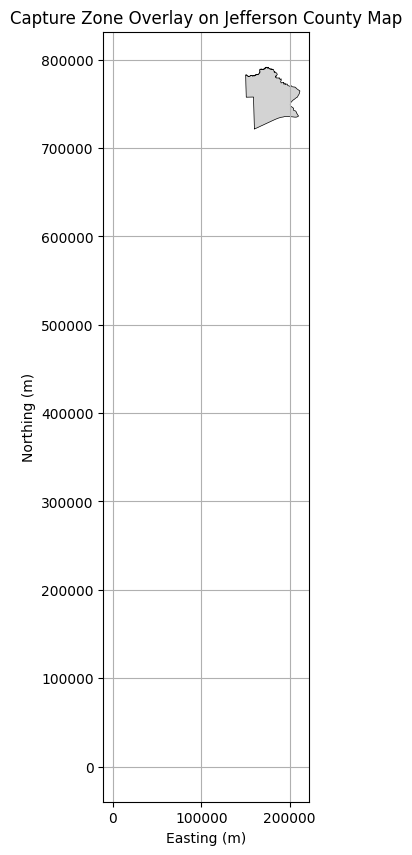

In [82]:
import matplotlib.pyplot as plt

# Load Jefferson County boundary map
jefferson_county_gdf = gpd.read_file("JeffersonWGS84.gpkg")

# Transform Jefferson County map to AEA projection for alignment
jefferson_county_gdf = jefferson_county_gdf.to_crs(albers_proj)

# Plot Jefferson County with capture zone overlay
fig, ax = plt.subplots(figsize=(10, 10))
jefferson_county_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5)
rotated_capture_zone_gdf.plot(ax=ax, color="blue", alpha=0.5, edgecolor="blue")

# Embellishments
ax.set_title("Capture Zone Overlay on Jefferson County Map")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.grid()
plt.show()

In [85]:
# Assuming `water_levels_gdf` contains 'X', 'Y', and 'WaterElevation'
x_coords = water_levels_gdf["LongitudeDD"]
y_coords = water_levels_gdf["LatitudeDD"]
hydraulic_head = water_levels_gdf["WaterElevation"]

# Linear regression on X coordinates
slope_x, intercept_x, r_value_x, p_value_x, std_err_x = linregress(x_coords, hydraulic_head)

# Linear regression on Y coordinates
slope_y, intercept_y, r_value_y, p_value_y, std_err_y = linregress(y_coords, hydraulic_head)

print("Slope (gradient) along X:", slope_x)
print("Slope (gradient) along Y:", slope_y)

Slope (gradient) along X: -0.0005091280812255789
Slope (gradient) along Y: 0.00025286516016162437


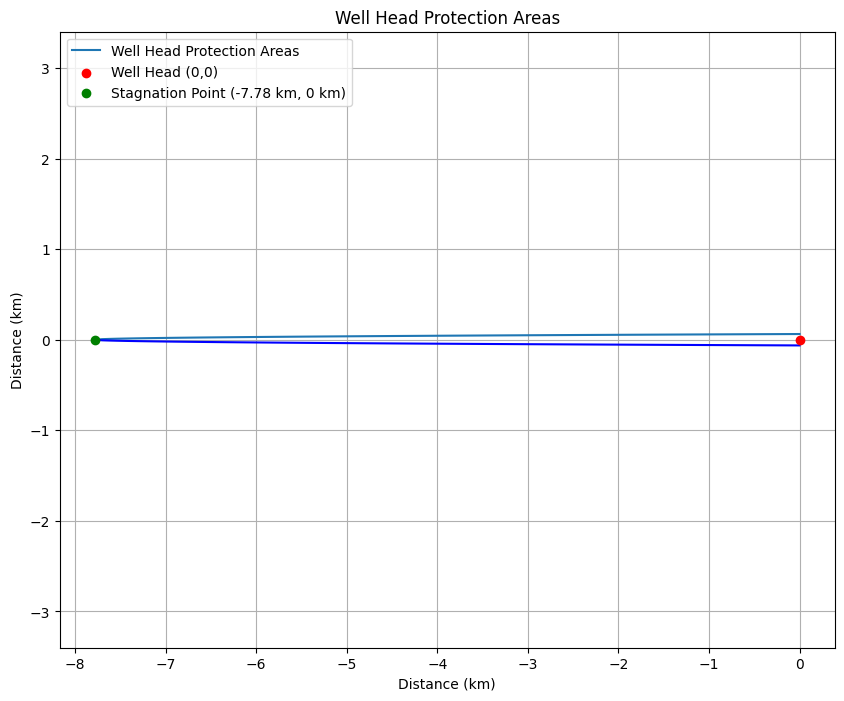

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Define the well head and stagnation point coordinates
well_head_x = 0
well_head_y = 0

# Assuming a stagnation point at a known distance along the x-axis upstream
stagnation_point_x = -7.78  # Example x-coordinate of the stagnation point (in km)
stagnation_point_y = 0

# Use the gradients from previous calculations to determine the shape of the curve
# For illustration, let's assume the gradients were calculated as follows:
slope_x = -0.0005091280812255789 
slope_y = 0.00025286516016162437

# Generate x values for the curve from the stagnation point to the well head
x = np.linspace(stagnation_point_x, well_head_x, 100)

# Define a parabolic function for the y-values using the slopes as coefficients
y = np.sqrt(abs(slope_x) * (x - stagnation_point_x))  # Adjust the coefficient to control the curve shape

# Plotting
plt.figure(figsize=(10, 8))

# Plot the curve
plt.plot(x, y, label="Well Head Protection Areas")
plt.plot(x, -y, color='blue')  # Symmetric part of the curve

# Plot the well head point
plt.scatter(well_head_x, well_head_y, color="red", label="Well Head (0,0)", zorder=5)

# Plot the stagnation point
plt.scatter(stagnation_point_x, stagnation_point_y, color="green", 
            label=f"Stagnation Point ({stagnation_point_x} km, 0 km)", zorder=5)

# Labels and grid
plt.xlabel("Distance (km)")
plt.ylabel("Distance (km)")
plt.title("Well Head Protection Areas")
plt.legend(loc="upper left")
plt.grid(True)
plt.axis('equal')  # Ensure the plot is square for correct proportions

# Show plot
plt.show()